In [15]:
# ! rm -r AI_USI_MA/
# !git clone https://github.com/UmbertoJr/AI_USI_MA.git

Student: Luca Pernigo

# The Orienteering Problem with Time Windows

column of X:

0. index of the customer
1. x coordinate
2. y coordinate
3. lower time window
4. uppper time window
5. reward customer
6. global time constraint

adj is the distance matrix

Problem n.0

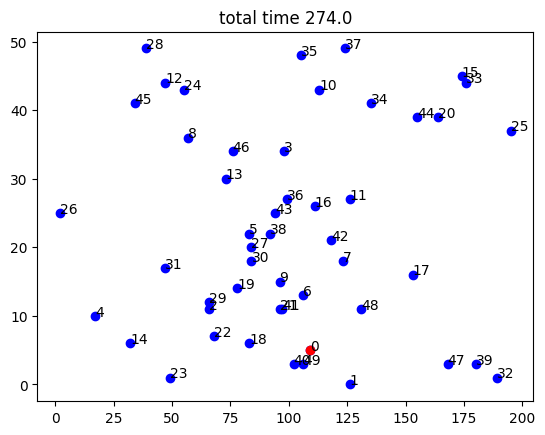

[[0.00e+00 1.09e+02 5.00e+00 0.00e+00 2.74e+02 0.00e+00 2.74e+02]
 [1.00e+00 1.26e+02 0.00e+00 2.13e+02 2.32e+02 1.70e-01 2.74e+02]
 [2.00e+00 6.60e+01 1.10e+01 2.31e+02 2.31e+02 4.00e-01 2.74e+02]
 [3.00e+00 9.80e+01 3.40e+01 1.31e+02 1.69e+02 2.90e-01 2.74e+02]
 [4.00e+00 1.70e+01 1.00e+01 1.82e+02 1.82e+02 8.40e-01 2.74e+02]]
(50, 7)
(50, 50)


In [16]:
import numpy as np
from AI_USI_MA.OPTW import Env, plot_instance

# env is the object containing OPTW problem infos
env = Env(from_file=True, instance_number=0)
# cast problem info to np array
X = np.array(env.x)
adj = env.adj
plot_instance(X)

# print info of first five cities
print(X[:5])

# cities x seven attributes
print(X.shape)

# this instance has 50 cities
print(adj.shape)

Problem n.1

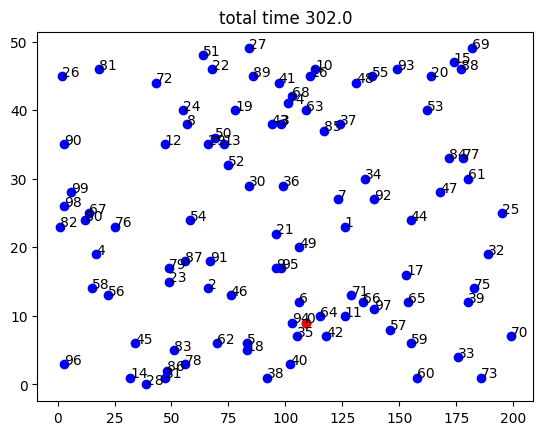

[[0.00e+00 1.09e+02 9.00e+00 0.00e+00 3.02e+02 0.00e+00 3.02e+02]
 [1.00e+00 1.26e+02 2.30e+01 2.06e+02 2.25e+02 2.00e-01 3.02e+02]
 [2.00e+00 6.60e+01 1.40e+01 4.00e+01 7.10e+01 3.80e-01 3.02e+02]
 [3.00e+00 9.80e+01 3.80e+01 1.17e+02 1.49e+02 2.80e-01 3.02e+02]
 [4.00e+00 1.70e+01 1.90e+01 2.09e+02 2.09e+02 8.20e-01 3.02e+02]]
(100, 7)
(100, 100)


In [17]:
env = Env(from_file=True, instance_number=1)
X = np.array(env.x)
adj = env.adj
plot_instance(X)
print(X[:5])
print(X.shape)
print(adj.shape)

Problem n.2

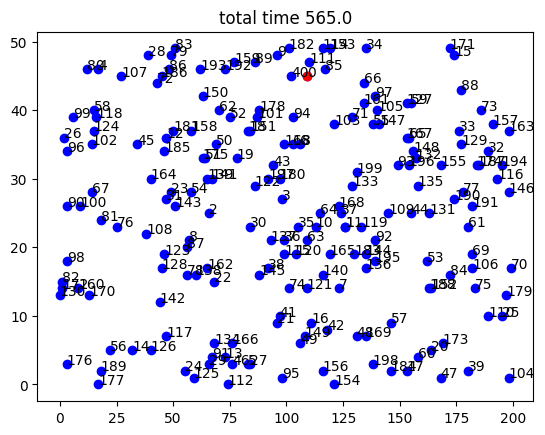

[[0.00e+00 1.09e+02 4.50e+01 0.00e+00 5.65e+02 0.00e+00 5.65e+02]
 [1.00e+00 1.26e+02 2.30e+01 1.41e+02 1.78e+02 2.50e-01 5.65e+02]
 [2.00e+00 6.60e+01 2.50e+01 5.18e+02 5.18e+02 4.10e-01 5.65e+02]
 [3.00e+00 9.80e+01 2.70e+01 2.40e+01 7.10e+01 1.90e-01 5.65e+02]
 [4.00e+00 1.70e+01 4.60e+01 4.73e+02 4.73e+02 8.00e-01 5.65e+02]]
(200, 7)
(200, 200)


In [18]:
env = Env(from_file=True, instance_number=2)
X = np.array(env.x)
adj = env.adj
plot_instance(X)
print(X[:5])
print(X.shape)
print(adj.shape)

In [22]:
# check if solution is feasible and print it

In [20]:
# env.adj[1, 49]

In [21]:
# X[18]

time window violated 225.0 
current time  233.0 
from node 1  to  49
(233.0, 0, False)


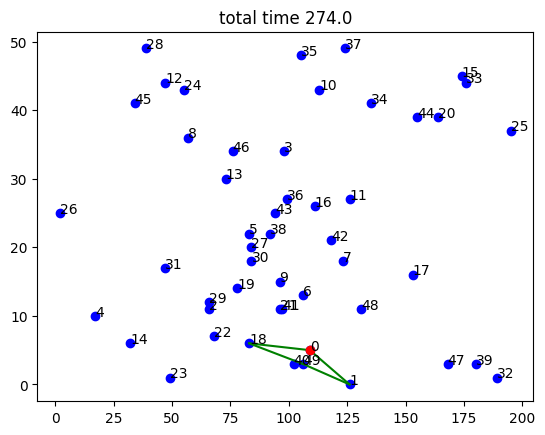

In [23]:
# proposed solution for problem 0
sol = [0, 1, 49, 18, 0]

# load instance
env = Env(from_file=True, instance_number=0, verbose=True)

# check solution with in built function
print(env.check_solution(sol))

# visualize solution

# if we fail to stick to times reward is zero
# False stands for that the proposed solution is not feasibile
plot_instance(env.x, sol)

(236.0, 0.44999999999999996, True)


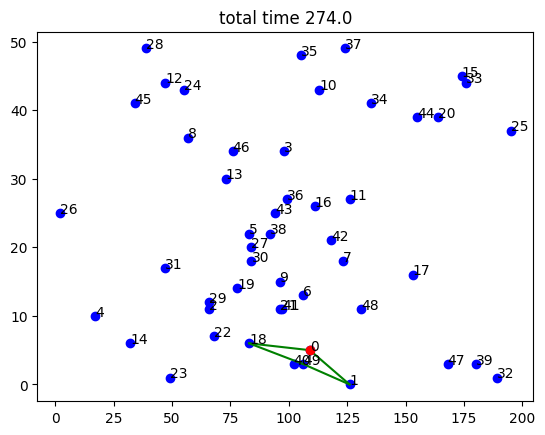

In [24]:
sol = [0, 18, 49, 1, 0]
env = Env(from_file=True, instance_number=0, verbose=True)

# this solution is feasible
print(env.check_solution(sol))
plot_instance(env.x, sol)

# Monte Carlo Tree Search

### Node class for the Tree Search


In [25]:
### Node Object ###
class Node:
    def __init__(self, parent, node, travel_time, partial_path, current_reward, expandable_customers):
      self.parent = parent                                                      # parent node object
      self.node = node                                                          # current node (or customer) index
      self.partial_path = partial_path                                          # current partial path across customers
      self.current_reward = current_reward                                      # current reward collected in the partial path
      self.num_of_visit = 0                                                     # number of visit to the current node during the MCTS
      self.terminal = False                                                     # boolean to determine if node is terminal
      self.fully_expanded = False                                               # boolean to determine if node was expanded completely during the search
      self.estimated_reward = 0                                                 # esteem of the future reward collected thanks to the MC simulations
      self.travel_time = travel_time                                            # travel time spent with the current partial path
      self.score = None                                                         # Upper Confidence Buond score for node
      self.policy = None                                                        # IMPORTANT !!!!! Best node index according to the UCB score
      self.expandables = copy.deepcopy(expandable_customers)             # customers in the candidate list of the current node that are not in the current path
      self.expanded = {}                                                        # nodes already expanded during the search
      if len(self.expandables) == 0:
        self.fully_expanded = True
        self.terminal = True
        self.partial_path.append(0)
        self.policy = 0

    def calculateUCTscore(self, best_reward_so_far):
      # computes the Upper Confidence Bound for the Node
      c=1/(2**0.5)
      self.score = (((self.estimated_reward/ self.num_of_visit) + self.current_reward) /
                    best_reward_so_far) + c * 2 * (2 * np.log(self.parent.num_of_visit) /
                                                   self.num_of_visit) ** 0.5


### MCTS

In [26]:
from time import time
import copy
import numpy as np
from scipy.special import softmax
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')


class MCTS:
  def __init__(self, env,time_limit, initial_path):
    self.num_of_customers = env.n_nodes                                         # number of customers in the current problem
    self.env = env                                                              # environment of the problem to solve
    self.time_limit = time_limit                                                # time budget for the OPTW to solve
    self.initial_path = initial_path                                            # initial path=[0]
    self.root_node = initial_path[-1]                                           # root node index, node 0

    # saving the best tour so far, its reward and time travel
    self.best_tour_so_far = initial_path + [0]
    travel_time, self.max_reward, _ = self.env.check_solution(self.best_tour_so_far)

    # these operations find the promising CL for the root node
    ordered_view = {i: self.env.x[i, 5]/(self.env.x[i, 3] / self.env.x[i, 6]) for i in range(1, self.num_of_customers) if i not in initial_path
                    and self.env.adj[self.root_node, i] + travel_time < self.env.x[i, 4]
                    and self.env.adj[i, 0] + self.env.adj[self.root_node, i] + travel_time < self.env.x[i, 6]}
    ordered_list = [k for k, v in sorted(ordered_view.items(), key=lambda item: item[1]) if k not in initial_path]

    # initialize the root node
    self.root = Node(parent=None,
                     node= self.root_node,
                     travel_time =travel_time,
                     partial_path=initial_path,
                     current_reward=0,
                     expandable_customers = ordered_list)


  def treePolicy(self, node):
    """
    This function expand a node if the selected node is not being completely expanded,
    otherwise it select the best child in the Tree using the selectBestChild function
    """
    # TO DO
    # while node is not terminal-> that is node.terminal is False
    while node.terminal==False:
        # if node is not fully expanded-> that is node.fully_expanded is False
        if node.fully_expanded==False:
            return self.expand(node)
        # else find best child
        else:
            node=self.selectBestChild(node)
      
    return node


  def selectBestChild(self, node):
    """
    The function updates the UBC score for each child node by employing the updated max_reward
    then it returns the best child according to such score.
    """
    best_score = 0
    best_child = None
    # TO DO
    # for every child of node
    for child_key, child in node.expanded.items():
        # compute score for each children
        # notice that the already implemented function updates also the score for each children
        child.calculateUCTscore(self.max_reward)

        # at each step check which is the best child
        if child.score>best_score:
            # then update score and best_child
            best_score=child.score

            best_child=child
      
    return best_child


  def expand(self, node):
    new_node = node.expandables.pop()                                           # it selects the most promising node from the CL
    new_path = copy.deepcopy(node.partial_path)                                 # it copies the path and append new node to it
    new_path.append(new_node)

    new_reward = node.current_reward                                            # update of the reward for the new customer
    new_reward += self.env.x[new_node, 5]

    new_travel_time = max(node.travel_time + self.env.adj[node.node, new_node], # updated the travel time
                          self.env.x[new_node, 3])

    # these operations find the promising CL for the root node
    ordered_view = {i: self.env.x[i, 5]/(self.env.x[i, 3] / self.env.x[i, 6]) for i in range(1, self.num_of_customers) if i not in new_path
                    and self.env.adj[new_node, i] + new_travel_time < self.env.x[i, 4]
                    and self.env.adj[i, 0] + self.env.adj[new_node, i] + new_travel_time < self.env.x[i, 6]}
    ordered_list = [k for k, v in sorted(ordered_view.items(), key=lambda item: item[1]) if k not in new_path]

    new_node_object = Node(parent=node,
                           node=new_node,
                           travel_time=new_travel_time,
                           partial_path=new_path,
                           current_reward=new_reward,
                           expandable_customers=ordered_list)

    node.expanded[new_node] = new_node_object
    if len(node.expandables) == 0:
      node.fully_expanded = True

    if new_node == 0:
      new_node_object.terminal = True
      _, new_r, _ = self.env.check_solution(new_path)
      if new_r > self.max_reward:
        self.max_reward = new_r
        self.best_tour_so_far = new_path

    return new_node_object

  def defaultPolicy(self, starting_node):
    # reach the end, break condition
    if starting_node.node == 0:
      return 0

    customer = starting_node.node
    new_path = starting_node.partial_path
    travel_time = starting_node.travel_time
    while customer != 0:
      # these operations find the promising CL for the root node
      ordered_view = {i: (self.env.x[i, 5] + np.finfo(float).eps)/(self.env.x[i, 3] / self.env.x[i, 6] + np.finfo(float).eps ) for i in range(1, self.num_of_customers) if i not in new_path
                      and self.env.adj[customer, i] + travel_time < self.env.x[i, 4]
                      and self.env.adj[i, 0] + self.env.adj[customer, i] + travel_time < self.env.x[i, 6]}
      ordered_list = [k for k, v in sorted(ordered_view.items(), key=lambda item: -item[1]) if k not in new_path]
      if len(ordered_list) == 0:
        customer = 0
      else:
        probabilities = softmax(np.array([v for k, v in sorted(ordered_view.items(), key=lambda item: -item[1]) if k not in new_path]))
        customer = int(np.random.choice(ordered_list, 1, p=probabilities))

      new_path.append(customer)
      travel_time = max(travel_time + self.env.adj[new_path[-2], customer], self.env.x[customer, 3])

    _, new_r, _ = self.env.check_solution(new_path)
    if new_r > self.max_reward:
        self.max_reward = new_r
        self.best_tour_so_far = new_path

    return new_r - starting_node.current_reward


  def backup(self, node, reward_esteem):
    """
    backup of the estimated reward in the MCTS
    """
    # TO DO
    while node!=None:
        # update N(v) which is the number of node has been visited
        node.num_of_visit+=1
        # update Q(v) which is the estimated reward for node
        node.estimated_reward+=reward_esteem

        # move back in the tree
        node=node.parent
    pass

  def step(self, num_of_simulation=1):
    start = time()
    while time() - start < self.time_limit:
        current_node = self.treePolicy(self.root)
        reward_esteem = self.defaultPolicy(current_node)
        self.backup(current_node, reward_esteem)

    return self.root.policy if self.root.policy != None else 0

### Solve problems 0,1,2

(0, 0.0, True)


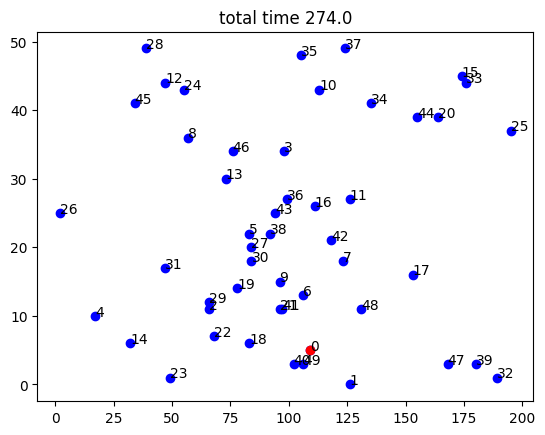

(274.0, 1.73, True)


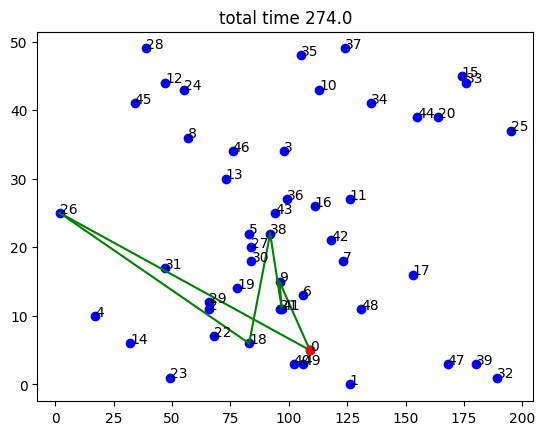

In [36]:
env = Env(from_file=True, instance_number=0)
time_limit = 5
sol = [0]
best_sol = None
best_r = 0
while True:
  
  mcts = MCTS(env, time_limit, sol)
  mcts.best_tour_so_far = best_sol
  mcts.max_reward = best_r
  new_customer = mcts.step()
  # print("a new customer is", new_customer)
  sol.append(new_customer)
  if mcts.max_reward > best_r:
    best_r = mcts.max_reward
    best_sol = mcts.best_tour_so_far
  if sol[-1] == 0:
    break


print(env.check_solution(sol))
plot_instance(env.x, sol)
print(env.check_solution(best_sol))
plot_instance(env.x, best_sol)

(0, 0.0, True)


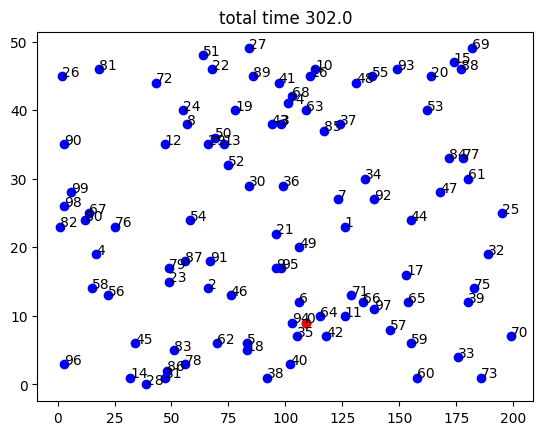

(302.0, 1.35, True)


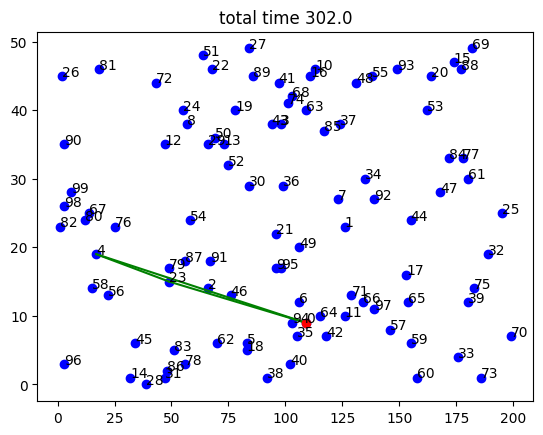

In [27]:
env = Env(from_file=True, instance_number=1)
time_limit = 5
sol = [0]
best_sol = None
best_r = 0
while True:
  mcts = MCTS(env, time_limit, sol)
  mcts.best_tour_so_far = best_sol
  mcts.max_reward = best_r
  new_customer = mcts.step()
  # print("a new customer is", new_customer)
  sol.append(new_customer)
  if mcts.max_reward > best_r:
    best_r = mcts.max_reward
    best_sol = mcts.best_tour_so_far
  if sol[-1] == 0:
    break

print(env.check_solution(sol))
plot_instance(env.x, sol)
print(env.check_solution(best_sol))
plot_instance(env.x, best_sol)

(0, 0.0, True)


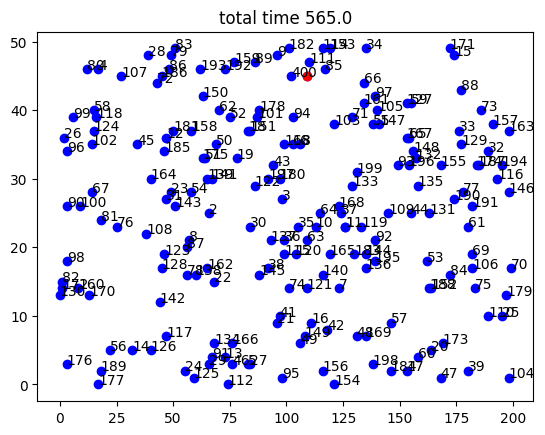

(565.0, 2.27, True)


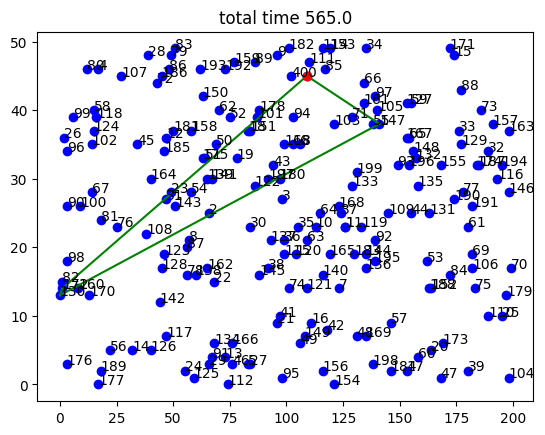

In [28]:
env = Env(from_file=True, instance_number=2)
time_limit = 5
sol = [0]
best_sol = None
best_r = 0
while True:
  mcts = MCTS(env, time_limit, sol)
  mcts.best_tour_so_far = best_sol
  mcts.max_reward = best_r
  new_customer = mcts.step()
  sol.append(new_customer)
  if mcts.max_reward > best_r:
    best_r = mcts.max_reward
    best_sol = mcts.best_tour_so_far
  if sol[-1] == 0:
    break

print(env.check_solution(sol))
plot_instance(env.x, sol);
print(env.check_solution(best_sol))
plot_instance(env.x, best_sol)

### Evaluation Strategy

In [29]:
def evaluation(seeds, instance_number):
    
    res_list=[]
    for seed in seeds:
        np.random.seed(seed)

        env = Env(from_file=True, instance_number=instance_number)
        time_limit = 5
        sol = [0]
        best_sol = None
        best_r = 0
        while True:
  
          mcts = MCTS(env, time_limit, sol)
          mcts.best_tour_so_far = best_sol
          mcts.max_reward = best_r
          new_customer = mcts.step()
          # print("a new customer is", new_customer)
          sol.append(new_customer)
          if mcts.max_reward > best_r:
            best_r = mcts.max_reward
            best_sol = mcts.best_tour_so_far
          if sol[-1] == 0:
            break

        res_list+=[env.check_solution(best_sol)]
    
    return res_list

In [30]:
eval_prbml0=evaluation([0,42,666], 0)

In [31]:
eval_prbml1=evaluation([0,42,666], 1)

In [32]:
eval_prbml2=evaluation([0,42,666], 2)

In [33]:
import pandas as pd

In [34]:
seeds=[0,42,666]

In [35]:
index_array = [
    np.repeat(np.array(["instance0", "instance1", "instance2"]),3),
    seeds*3
]

index = pd.MultiIndex.from_tuples(list(zip(*index_array)), names=["ProblemInstance", "Seed"])


In [37]:
df=pd.DataFrame(eval_prbml0+eval_prbml1+eval_prbml2, columns=["TotalTime","Reward","Feasibility"], index=index)
df

TotalTime  Reward  Feasibility
ProblemInstance Seed                                
instance0       0         274.0    2.13         True
                42        274.0    1.66         True
                666       274.0    1.43         True
instance1       0         302.0    1.68         True
                42        302.0    1.35         True
                666       301.0    1.74         True
instance2       0         565.0    2.07         True
                42        565.0    2.78         True
                666       565.0    2.53         True

In [47]:
df.groupby('ProblemInstance')[['TotalTime', 'Reward', 'Feasibility']].mean()


,TotalTime,Reward,Feasibility
ProblemInstance,,,
instance0,274.000000,1.74,1.0
instance1,301.666667,1.59,1.0
instance2,565.000000,2.46,1.0
